In [ ]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning
import matplotlib.dates as mdates
from statsmodels.tsa.vector_ar.vecm import VECM

## Data Preperation

- Saving all the CSVs with descriptive names in the Folder ./original_data
- In case of XML Files the were converted to CSVs

### Google Data:

- Manuel removal of the first two rows and the region (Deutschland)
- To get weekly Data it was necessary to download several 5 year intervals and normalize/stitching them together
- Logarithmierung: Yes, because search interest data often exhibits exponential growth or decay, and log transformation helps stabilize variance and linearize trends.

### AGPI & Gebrauchtwagenpreiseindex:

- Only available on a monthly basis values were assigned to the last day of the month
- Logarithmierung: Yes, because price indices can show multiplicative effects over time, and logs convert these to additive effects, stabilizing variance.

### Arbeitslosenzahlen:

- Loaded from CSV, cleaned numeric columns (removing thousands separators, converting to appropriate types).
- 'Berichtsmonat' (reporting month) string converted to datetime objects, set to the last day of the month.
- Logarithmierung: No, the raw figures were used directly as they represent counts and rates which are often analyzed in their original scale or after differencing for stationarity.

### Euribor:

- Data for 3-month, 6-month, and 12-month Euribor rates loaded from separate CSVs.
- Unnecessary "TIME PERIOD" column dropped and columns renamed for clarity.
- Dates were already in a usable monthly format.
- Logarithmierung: No, interest rates are typically analyzed in their original percentage scale, especially when they can be near zero or negative, where logs are undefined or behave poorly.

### ifo Beschäftigungsbarometer:

- Loaded from CSV.
- "DATE" column converted to datetime objects, set to the last day of the month, then formatted as string "YYYY-MM-DD".
- Logarithmierung: No, index values like this are often used directly or differenced.

### ifo Geschäftsklima:

- Loaded from CSV.
- "DATE" column (originally in "MM/YYYY" format) converted to datetime objects, set to the last day of the month, then formatted as string "YYYY-MM-DD".
- Logarithmierung: No, similar to the Beschäftigungsbarometer, these index values are typically analyzed in their original scale.

### BMW Sales:

- Loaded from CSV, with specified separator and decimal character.
- "DATE" column converted to datetime objects.
- Logarithmierung: Yes, sales data can exhibit multiplicative seasonality and growth, log transformation helps in stabilizing variance and making the series more amenable to time series modeling.

### Verbraucherpreisindex:

- Loaded from CSV, with specified separator and decimal character.
- Numeric columns representing various price indices cleaned (commas replaced with dots, converted to float).
- "Datum" (Date) column converted to datetime objects, set to the last day of the month.
- Logarithmierung: Yes, for the selected index columns, as price indices often have multiplicative components and log transformation helps in stabilizing variance and interpreting changes as percentage changes.


In [ ]:
# Log transform helper functions
def log_transform_series(series_to_log):
    return np.log(series_to_log.replace(0, np.nan))


def create_log_transformed_df(
    input_df, value_col_name, new_log_col_name, date_col_name="DATE"
):
    df_log = pd.DataFrame()
    df_log[date_col_name] = input_df[date_col_name]
    df_log[new_log_col_name] = log_transform_series(input_df[value_col_name])
    return df_log

In [ ]:
# google trends
def merge_and_normalize_trends(dfs, col_name):
    # Start with the first DataFrame
    result = dfs[0].copy()
    for next_df in dfs[1:]:
        # Find overlap
        overlap = set(result["Woche"]) & set(next_df["Woche"])
        if overlap:
            # Use the mean ratio in the overlap to normalize
            overlap = list(overlap)
            result_overlap = result[result["Woche"].isin(overlap)].set_index("Woche")
            next_overlap = next_df[next_df["Woche"].isin(overlap)].set_index("Woche")
            ratio = result_overlap[col_name].mean() / next_overlap[col_name].mean()
        else:
            ratio = 1.0
        # Normalize next_df
        next_df_norm = next_df.copy()
        next_df_norm[col_name] = next_df_norm[col_name] * ratio
        # Append only non-overlapping part
        non_overlap = ~next_df_norm["Woche"].isin(result["Woche"])
        result = pd.concat([result, next_df_norm[non_overlap]], ignore_index=True)
    # Sort by date
    result = result.sort_values("Woche").reset_index(drop=True)
    return result


# Keyword: "Auto Finanzierung"
gt_auto_finanzierung_1 = pd.read_csv("./original_data/gt_auto_finanzierung_1.csv")
gt_auto_finanzierung_2 = pd.read_csv("./original_data/gt_auto_finanzierung_2.csv")
gt_auto_finanzierung_3 = pd.read_csv("./original_data/gt_auto_finanzierung_3.csv")

gt_auto_finanzierung = merge_and_normalize_trends(
    [gt_auto_finanzierung_1, gt_auto_finanzierung_2, gt_auto_finanzierung_3],
    col_name="Auto Finanzierung",
)
gt_auto_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
gt_auto_finanzierung["DATE"] = pd.to_datetime(gt_auto_finanzierung["DATE"])
# Keyword: "BMW Finanzierung"
gt_bmw_finanzierung_1 = pd.read_csv("./original_data/gt_bmw_finanzierung_1.csv")
gt_bmw_finanzierung_2 = pd.read_csv("./original_data/gt_bmw_finanzierung_2.csv")
gt_bmw_finanzierung_3 = pd.read_csv("./original_data/gt_bmw_finanzierung_3.csv")

gt_bmw_finanzierung = merge_and_normalize_trends(
    [gt_bmw_finanzierung_1, gt_bmw_finanzierung_2, gt_bmw_finanzierung_3],
    col_name="BMW Finanzierung",
)
gt_bmw_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw_finanzierung["DATE"] = pd.to_datetime(gt_bmw_finanzierung["DATE"])
# Keyword: "Auto Leasing"
gt_auto_leasing_1 = pd.read_csv("./original_data/gt_auto_leasing_1.csv")
gt_auto_leasing_2 = pd.read_csv("./original_data/gt_auto_leasing_2.csv")
gt_auto_leasing_3 = pd.read_csv("./original_data/gt_auto_leasing_3.csv")

gt_auto_leasing = merge_and_normalize_trends(
    [gt_auto_leasing_1, gt_auto_leasing_2, gt_auto_leasing_3], col_name="Auto Leasing"
)
gt_auto_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_auto_leasing["DATE"] = pd.to_datetime(gt_auto_leasing["DATE"])
# Keyword: "BMW Leasing"
gt_bmw_leasing_1 = pd.read_csv("./original_data/gt_bmw_leasing_1.csv")
gt_bmw_leasing_2 = pd.read_csv("./original_data/gt_bmw_leasing_2.csv")
gt_bmw_leasing_3 = pd.read_csv("./original_data/gt_bmw_leasing_3.csv")
gt_bmw_leasing = merge_and_normalize_trends(
    [gt_bmw_leasing_1, gt_bmw_leasing_2, gt_bmw_leasing_3], col_name="BMW Leasing"
)
gt_bmw_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw_leasing["DATE"] = pd.to_datetime(gt_bmw_leasing["DATE"])
# Keyword: "Leasing"
gt_leasing_1 = pd.read_csv("./original_data/gt_leasing_1.csv")
gt_leasing_2 = pd.read_csv("./original_data/gt_leasing_2.csv")
gt_leasing_3 = pd.read_csv("./original_data/gt_leasing_3.csv")
gt_leasing = merge_and_normalize_trends(
    [gt_leasing_1, gt_leasing_2, gt_leasing_3], col_name="leasing"
)
gt_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_leasing["DATE"] = pd.to_datetime(gt_leasing["DATE"])
# Keyword: "BMW"
gt_bmw_1 = pd.read_csv("./original_data/gt_bmw_1.csv")
gt_bmw_2 = pd.read_csv("./original_data/gt_bmw_2.csv")
gt_bmw_3 = pd.read_csv("./original_data/gt_bmw_3.csv")
gt_bmw = merge_and_normalize_trends([gt_bmw_1, gt_bmw_2, gt_bmw_3], col_name="BMW")
gt_bmw.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw["DATE"] = pd.to_datetime(gt_bmw["DATE"])


# Log transform
gt_bmw_leasing_log = create_log_transformed_df(
    gt_bmw_leasing, "BMW Leasing", "BMWLeasing"
)
gt_bmw_finanzierung_log = create_log_transformed_df(
    gt_bmw_finanzierung, "BMW Finanzierung", "BMWFinanzierung"
)
gt_auto_finanzierung_log = create_log_transformed_df(
    gt_auto_finanzierung, "Auto Finanzierung", "AutoFinanzierung"
)
gt_auto_leasing_log = create_log_transformed_df(
    gt_auto_leasing, "Auto Leasing", "AutoLeasing"
)
gt_leasing_log = create_log_transformed_df(gt_leasing, "leasing", "leasing")
gt_bmw_log = create_log_transformed_df(gt_bmw, "BMW", "BMW")

In [ ]:
# agpi
agpi = pd.read_csv("./original_data/agpi.csv")

agpi["DATE"] = pd.to_datetime(agpi["DATE"], format="%Y-%m") + pd.offsets.MonthEnd(0)
# agpi["DATE"] = agpi["DATE"].dt.strftime("%Y-%m-%d") # Keep as datetime

agpi_log = create_log_transformed_df(agpi, "AGPI", "AGPI")

In [ ]:
# gebrauchtwagenpreiseindex

gebrauchtwagenpreisindex = pd.read_csv("./original_data/gebrauchtwagenpreisindex.csv")
gebrauchtwagenpreisindex["DATE"] = pd.to_datetime(
    gebrauchtwagenpreisindex["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)

gebrauchtwagenpreisindex_log = create_log_transformed_df(
    gebrauchtwagenpreisindex, "Gebrauchtwagenpreisindex", "Gebrauchtwagenpreisindex"
)

In [ ]:
# arbeitslosenzahlen

month_map = {
    "Januar": "01",
    "Februar": "02",
    "März": "03",
    "April": "04",
    "Mai": "05",
    "Juni": "06",
    "Juli": "07",
    "August": "08",
    "September": "09",
    "Oktober": "10",
    "November": "11",
    "Dezember": "12",
}
arbeitslosenquote = pd.read_csv(
    "./original_data/arbeitslosenzahlen.csv", sep=";", decimal=","
)

# Clean integer columns (remove dots, convert to int)
for col in ["Bestand Arbeitslose", "Zugang Arbeitslose", "Abgang Arbeitslose"]:
    arbeitslosenquote[col] = (
        arbeitslosenquote[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .replace("", "0")
        .astype(int)
    )

# Clean float column (replace comma with dot, convert to float)
arbeitslosenquote["Arbeitslosenquote"] = (
    arbeitslosenquote["Arbeitslosenquote"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .replace("", "0")
    .astype(float)
)

# Convert 'Berichtsmonat' to datetime
arbeitslosenquote["DATE"] = (
    arbeitslosenquote["Berichtsmonat"]
    .astype(str)
    .apply(
        lambda x: pd.to_datetime(
            f"{x.split(' ')[1]}-{month_map.get(x.split(' ')[0], '01')}-01",
            errors="coerce",
        )
    )
)
arbeitslosenquote["DATE"] = arbeitslosenquote["DATE"] + pd.offsets.MonthEnd(0)

# Reorder columns
arbeitslosenquote = arbeitslosenquote.drop(columns=["Berichtsmonat"])
arbeitslosenquote = arbeitslosenquote[
    ["DATE"] + [col for col in arbeitslosenquote.columns if col != "DATE"]
]

In [ ]:
# euribor
# 3 months
euribor_3m = pd.read_csv("./original_data/euribor_3m.csv")
euribor_3m = euribor_3m.drop(columns=["TIME PERIOD"])
euribor_3m = euribor_3m.rename(
    columns={
        "Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)": "Euribor 3M"
    }
)
# 6 months
euribor_6m = pd.read_csv("./original_data/euribor_6m.csv")
euribor_6m = euribor_6m.drop(columns=["TIME PERIOD"])
euribor_6m = euribor_6m.rename(
    columns={
        "Euribor 6-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR6MD_.HSTA)": "Euribor 6M"
    }
)
# 12 months
euribor_12m = pd.read_csv("./original_data/euribor_12m.csv")
euribor_12m = euribor_12m.drop(columns=["TIME PERIOD"])
euribor_12m = euribor_12m.rename(
    columns={
        "Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)": "Euribor 12M"
    }
)

In [ ]:
# ifo beschäftigungsbarometer
beschaeftigungsbarometer = pd.read_csv(
    "./original_data/ifo_beschaeftigungsbarometer.csv"
)
beschaeftigungsbarometer["DATE"] = pd.to_datetime(
    beschaeftigungsbarometer["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
beschaeftigungsbarometer["DATE"] = beschaeftigungsbarometer["DATE"].dt.strftime(
    "%Y-%m-%d"
)

In [ ]:
# ifo geschäftsklima
geschaeftsklima = pd.read_csv("./original_data/ifo_geschaeftsklima.csv")
geschaeftsklima["DATE"] = pd.to_datetime(
    geschaeftsklima["DATE"].str.strip(), format="%m/%Y"
) + pd.offsets.MonthEnd(0)
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].dt.strftime("%Y-%m-%d")

In [ ]:
# bmw sales
bmw_sales = pd.read_csv("./original_data/bmw_sales.csv", sep=";", decimal=",")
bmw_sales["DATE"] = pd.to_datetime(bmw_sales["DATE"])  # Ensure DATE is datetime

bmw_sales_log = create_log_transformed_df(bmw_sales, "SALES", "SALES")

In [ ]:
# verbraucherpreisindex
verbraucherpreisindex = pd.read_csv(
    "./original_data/verbraucherpreisindex.csv", sep=";", decimal=","
)

# Columns to clean: replace comma with period and convert to float
cols_to_clean_comma = [
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

for col in cols_to_clean_comma:
    verbraucherpreisindex[col] = (
        verbraucherpreisindex[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(
            ".", "0", regex=False
        )  # Handle cases where only a period might be left or as a placeholder
        .replace("", "0")  # Replace empty strings with 0
        .astype(float)
    )

# Convert "Datum" to datetime, then set to last day of month
verbraucherpreisindex["DATE"] = pd.to_datetime(
    verbraucherpreisindex["Datum"], format="%d/%m/%Y"
) + pd.offsets.MonthEnd(0)
# verbraucherpreisindex["DATE"] = verbraucherpreisindex["DATE"].dt.strftime("%Y-%m-%d") # Keep as datetime
verbraucherpreisindex = verbraucherpreisindex.drop(columns=["Datum"])
cols = ["DATE"] + [col for col in verbraucherpreisindex.columns if col != "DATE"]
verbraucherpreisindex = verbraucherpreisindex[cols]

# Log-transform selected columns (except DATE)
cols_to_log = [
    "Verbraucherpreisindex",
    "Index der Einzelhandelspreise",
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Growsshandelsverkaufspreise",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

verbraucherpreisindex_log = verbraucherpreisindex[["DATE"] + cols_to_log].copy()
for col in cols_to_log:
    verbraucherpreisindex_log[col] = log_transform_series(
        verbraucherpreisindex_log[col]
    )

## Data Merging, Interpolation and converting to a weekly-basis

### Merging

- Array with all the dataframes, which should be merged
- Using lambda function tou outer join all the dataframes using the DATE as a index
- Exporting merged dataframe to data.csv
- Describing the Data to gather more insights

### Interpolation

- Filling missing Values using interpolation via the time method

### Weekly-basis

- Using the Sunday of each Week as a common Basis


In [ ]:
# Merge all dataframes on DATE
from functools import reduce

dataframes = [
    bmw_sales_log,
    gt_auto_finanzierung_log,
    gt_bmw_finanzierung_log,
    gt_auto_leasing_log,
    gt_bmw_leasing_log,
    gt_leasing_log,
    gt_bmw_log,
    agpi_log,
    gebrauchtwagenpreisindex_log,
    euribor_3m,
    euribor_6m,
    euribor_12m,
    verbraucherpreisindex_log,
    arbeitslosenquote,
    beschaeftigungsbarometer,
    geschaeftsklima,
]

for df_item in dataframes:
    if "DATE" in df_item.columns:
        df_item["DATE"] = pd.to_datetime(df_item["DATE"])

df_merged = reduce(
    lambda left, right: pd.merge(left, right, on="DATE", how="outer"), dataframes
)
df_merged.columns = df_merged.columns.str.replace(r"\s+", "", regex=True)

In [ ]:
df_merged.describe()

In [ ]:
# Data transformation

# Ensure 'DATE' column is datetime
df_merged["DATE"] = pd.to_datetime(df_merged["DATE"])
df_merged = df_merged.sort_values("DATE").reset_index(drop=True)

# Interpolate on the original merged data
interpolated_on_original_timeline = (
    df_merged.set_index("DATE")
    .interpolate(method="time", limit_direction="both")
    .reset_index()
)

# Weekly (Sunday) index
all_sundays_index = pd.date_range(
    start=df_merged["DATE"].min(),
    end=df_merged["DATE"].max(),
    freq="W-SUN",
    name="DATE",
)

# Align the broadly interpolated data to the target weekly (Sunday) index
interpolated_on_original_timeline = interpolated_on_original_timeline.set_index("DATE")

# Reindex to the all_sundays_index
data_aligned_to_sundays = interpolated_on_original_timeline.reindex(all_sundays_index)

# Interpolate again to fill any NaNs created by reindexing to Sundays
df_interpolated = data_aligned_to_sundays.interpolate(
    method="time", limit_direction="both"
).reset_index()

final_start_date = pd.Timestamp("2015-01-01")
df_interpolated = df_interpolated[
    df_interpolated["DATE"] >= final_start_date
].reset_index(drop=True)

## Seasonal adjustment using STL

- Defining, which columns should be saisonal adjusted
- Using 52 as period, beause 52 weeks are in a year --> repetition


In [ ]:
# seasonal adjustment
from statsmodels.tsa.seasonal import STL

# List of columns to be seasonally adjusted
seasonal_cols = [
    "SALES",
    "AutoFinanzierung",
    "BMWFinanzierung",
    "AutoLeasing",
    "BMWLeasing",
    "leasing",
    "BMW",
    "AGPI",
    "Gebrauchtwagenpreisindex",
    "Euribor3M",
    "Euribor6M",
    "Euribor12M",
    "BestandArbeitslose",
    "ZugangArbeitslose",
    "AbgangArbeitslose",
    "Arbeitslosenquote",
    "Beschäftigungsbarometer",
    "VerarbeitendesGewerbe",
    "Bauhauptgewerbe",
    "Handel",
    "Dienstleistungssektor",
    "Geschäftsklima",
    "Geschäftslage",
    "Geschäftserwartungen",
    "Konjunkturampel",
]

df_sa = df_interpolated.copy()
df_sa = df_sa.set_index("DATE")

for col in seasonal_cols:
    if col in df_sa.columns:
        series = df_sa[col].dropna()
        if len(series) > 2 * 52:  # Check if enough data points (period=52 weeks)
            stl = STL(series, period=52, robust=True)
            res = stl.fit()
            df_sa[col] = pd.Series(res.trend + res.resid, index=series.index)
df_sa = df_sa.reset_index()

In [ ]:
# Plotting Function
def plot_time_series(df, title, x_col="DATE", y_cols=None):
    if y_cols is None:
        y_cols = [col for col in df.columns if col != x_col]  # All columns except x_col

    # Ensure x_col is datetime
    df_plot = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df_plot[x_col]):
        df_plot[x_col] = pd.to_datetime(df_plot[x_col])

    for col in y_cols:
        if col in df_plot.columns:  # Check if column exists
            plt.figure(figsize=(8, 4))
            plt.plot(df_plot[x_col], df_plot[col], label=col)
            plt.title(f"{title} - {col}")
            plt.xlabel("Date")
            plt.ylabel("Value")

            # Set x-axis major ticks to yearly
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")

In [ ]:
# plot_time_series(df_sa, "Time Series of SA")

In [ ]:
# Suppress warnings related to interpolation
warnings.filterwarnings("ignore", category=InterpolationWarning)


# ADF Test for Stationarity
def is_stationary_adf(series, significance_level=0.05, regression="ct"):
    result = adfuller(series, autolag="AIC", regression=regression)
    p_value = result[1]
    return p_value < significance_level


# KPSS Test for Stationarity
def is_stationary_kpss(series, significance_level=0.05, regression="ct"):
    result = kpss(series, regression=regression, nlags="auto")
    p_value = result[1]
    if p_value < significance_level:
        return False
    else:
        return True


# Overall Stationarity Test
def overall_stationarity_test(df_series):
    stationary = []
    non_stationary = []
    need_further_check = []

    for column in df_series.columns:
        if column == "DATE":
            continue

        adf_result = is_stationary_adf(df_series[column])
        kpss_result = is_stationary_kpss(df_series[column])

        if adf_result and kpss_result:
            stationary.append(column)
        elif not adf_result and not kpss_result:
            non_stationary.append(column)
        else:
            need_further_check.append(column)
    return {
        "stationary": stationary,
        "non_stationary": non_stationary,
        "need_further_check": need_further_check,
    }


# Plot ACF and PACF
def plot_acf_pacf(series, lags=52):
    for column in series:
        if column in df_sa.columns:
            series_to_plot = df_sa[column]

            if not series_to_plot.empty:
                fig, axes = plt.subplots(1, 2, figsize=(12, 4))

                # Plot ACF
                plot_acf(series_to_plot, ax=axes[0], lags=52)
                axes[0].set_title(f"ACF for {column}")

                # Plot PACF
                plot_pacf(series_to_plot, ax=axes[1], lags=52)
                axes[1].set_title(f"PACF for {column}")

                plt.suptitle(f"ACF and PACF for {column}", fontsize=14)
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

In [ ]:
stationarity_results = overall_stationarity_test(df_sa)
print(stationarity_results)

In [ ]:
# Further checks via ACF/PACF
plot_acf_pacf(df_sa[stationarity_results["need_further_check"]])

In [ ]:
cols_to_difference = (
    stationarity_results["non_stationary"] + stationarity_results["need_further_check"]
)

df_differenced = df_sa.copy()
df_differenced[cols_to_difference] = df_sa[cols_to_difference].diff(periods=1)

df_differenced = df_differenced.dropna()
df_differenced = df_differenced.reset_index(drop=True)

In [ ]:
stationarity_results_after_diff = overall_stationarity_test(df_differenced)
print(stationarity_results_after_diff)

In [ ]:
cols_for_secondary_diff = [
    "Euribor3M",
    "Euribor6M",
    "Euribor12M",
    "IndexderEinzelhandelspreise",
    "IndexderErzeugerpreisegewerblicherProdukte",
    "IndexderGrowsshandelsverkaufspreise",
    "IndexderAusfuhrpreise",
]

df_differenced[cols_for_secondary_diff] = df_differenced[cols_for_secondary_diff].diff(
    periods=1
)
df_differenced = df_differenced.dropna()
df_differenced = df_differenced.reset_index(drop=True)

In [ ]:
# Retest stationarity for the columns that underwent secondary differencing
stationarity_results = overall_stationarity_test(df_differenced)

In [ ]:
#  Plotting after Stationarity Tests
# plot_time_series(df_differenced, "Time Series of Stationarity")

In [ ]:
# feature engineering
df_fe = df_sa.copy()
df_differenced_fe = df_differenced.copy()

# Ensure DATE is datetime
for df_tmp in [df_fe, df_differenced_fe]:
    df_tmp["DATE"] = pd.to_datetime(df_tmp["DATE"])

# Create forward-lagged features for SALES at every 4 weeks up to 52 weeks
lags = range(4, 53, 4)
for lag in lags:
    df_fe[f"SALES_t+{lag}"] = df_fe["SALES"].shift(-lag)
    df_differenced_fe[f"SALES_t+{lag}"] = df_differenced_fe["SALES"].shift(-lag)


# Function to reorder columns
def reorder_columns(df, lagged_cols):
    base_cols = ["DATE", "SALES"]
    remaining_cols = [col for col in df.columns if col not in base_cols + lagged_cols]
    return df[base_cols + lagged_cols + remaining_cols]


# Define lagged columns once
lagged_cols = [f"SALES_t+{lag}" for lag in lags]

# Reorder columns for both dataframes
df_fe = reorder_columns(df_fe, lagged_cols)
df_differenced_fe = reorder_columns(df_differenced_fe, lagged_cols)

In [ ]:
def generate_correlation_heatmap(df, target_cols, other_cols):
    correlation_methods = ["pearson", "spearman"]
    for method in correlation_methods:
        correlation_matrix = df[target_cols + other_cols].corr(method=method)
        correlation_subset = correlation_matrix.loc[other_cols, target_cols]
        custom_palette = sns.diverging_palette(
            240, 10, s=80, l=55, n=256, center="light", as_cmap=True
        )

        plt.figure(figsize=(16, 12))
        sns.heatmap(
            correlation_subset,
            annot=True,
            fmt=".2f",
            vmin=-0.75,
            vmax=0.75,
            center=0,
            cmap=custom_palette,  
            annot_kws={"size": 12},
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
        )
        plt.title(
            f"{method.capitalize()} Correlation Heatmap: SALES (and lags) vs. Other Variables",
            fontsize=20,
            fontweight="bold",
        )
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

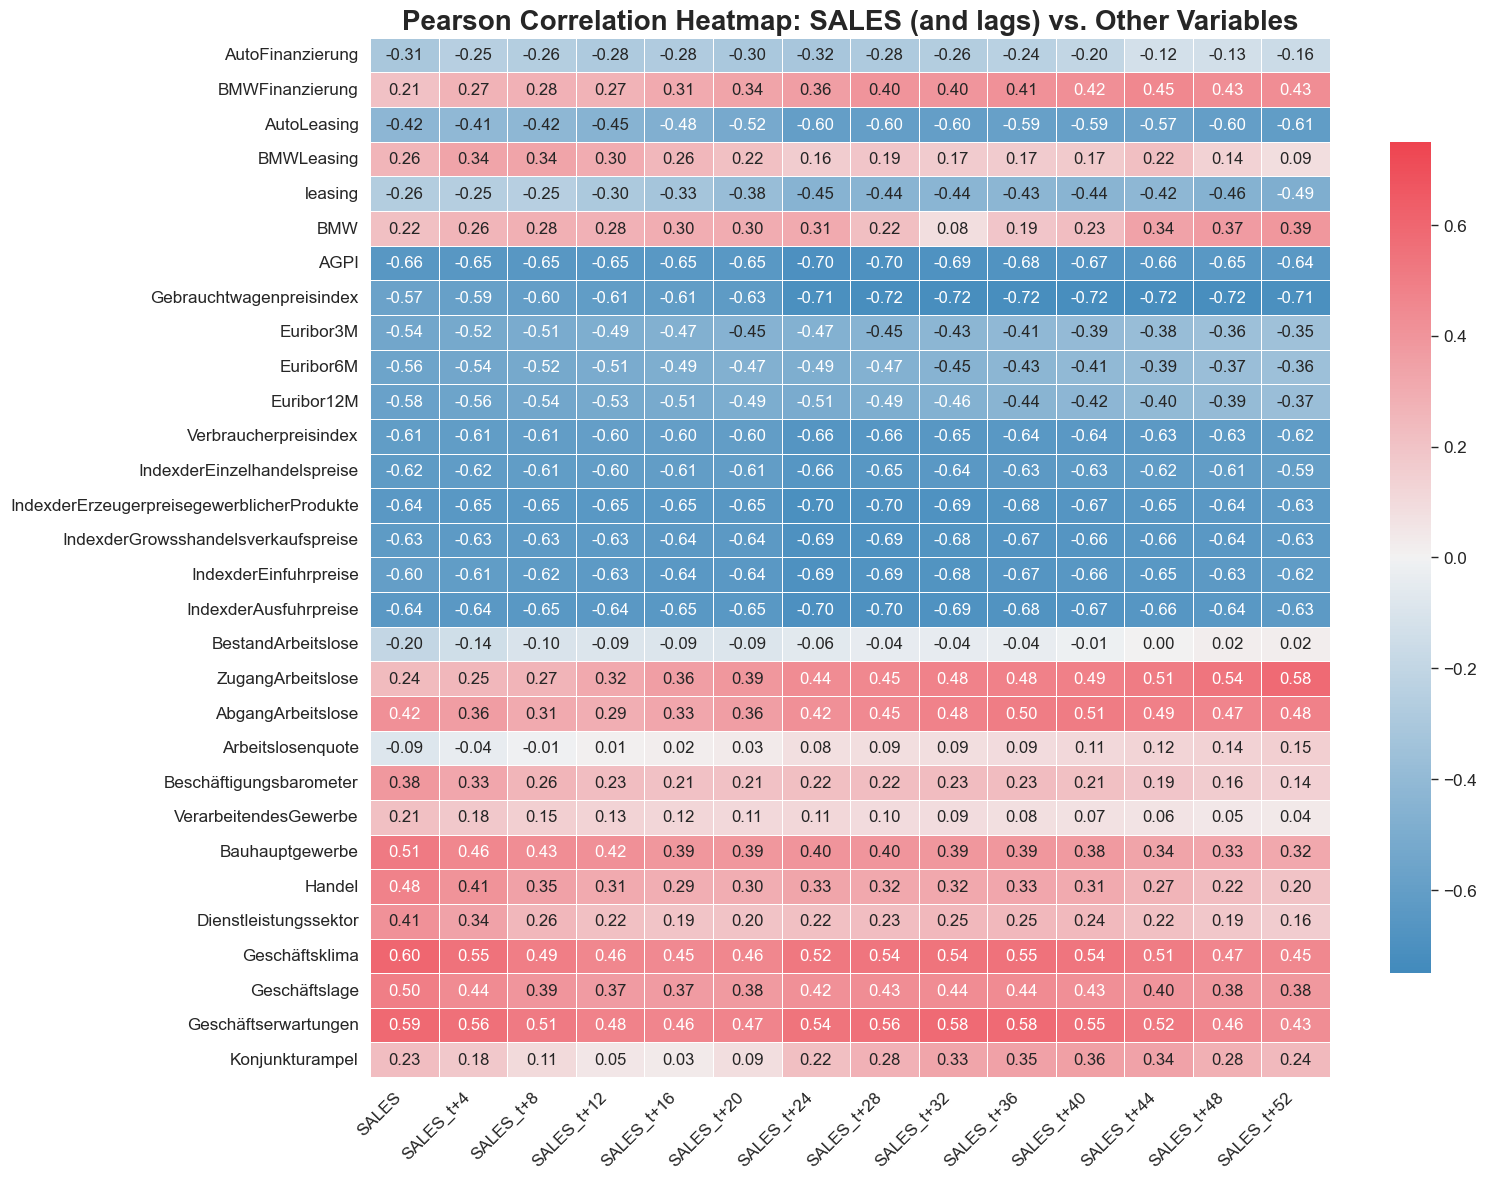

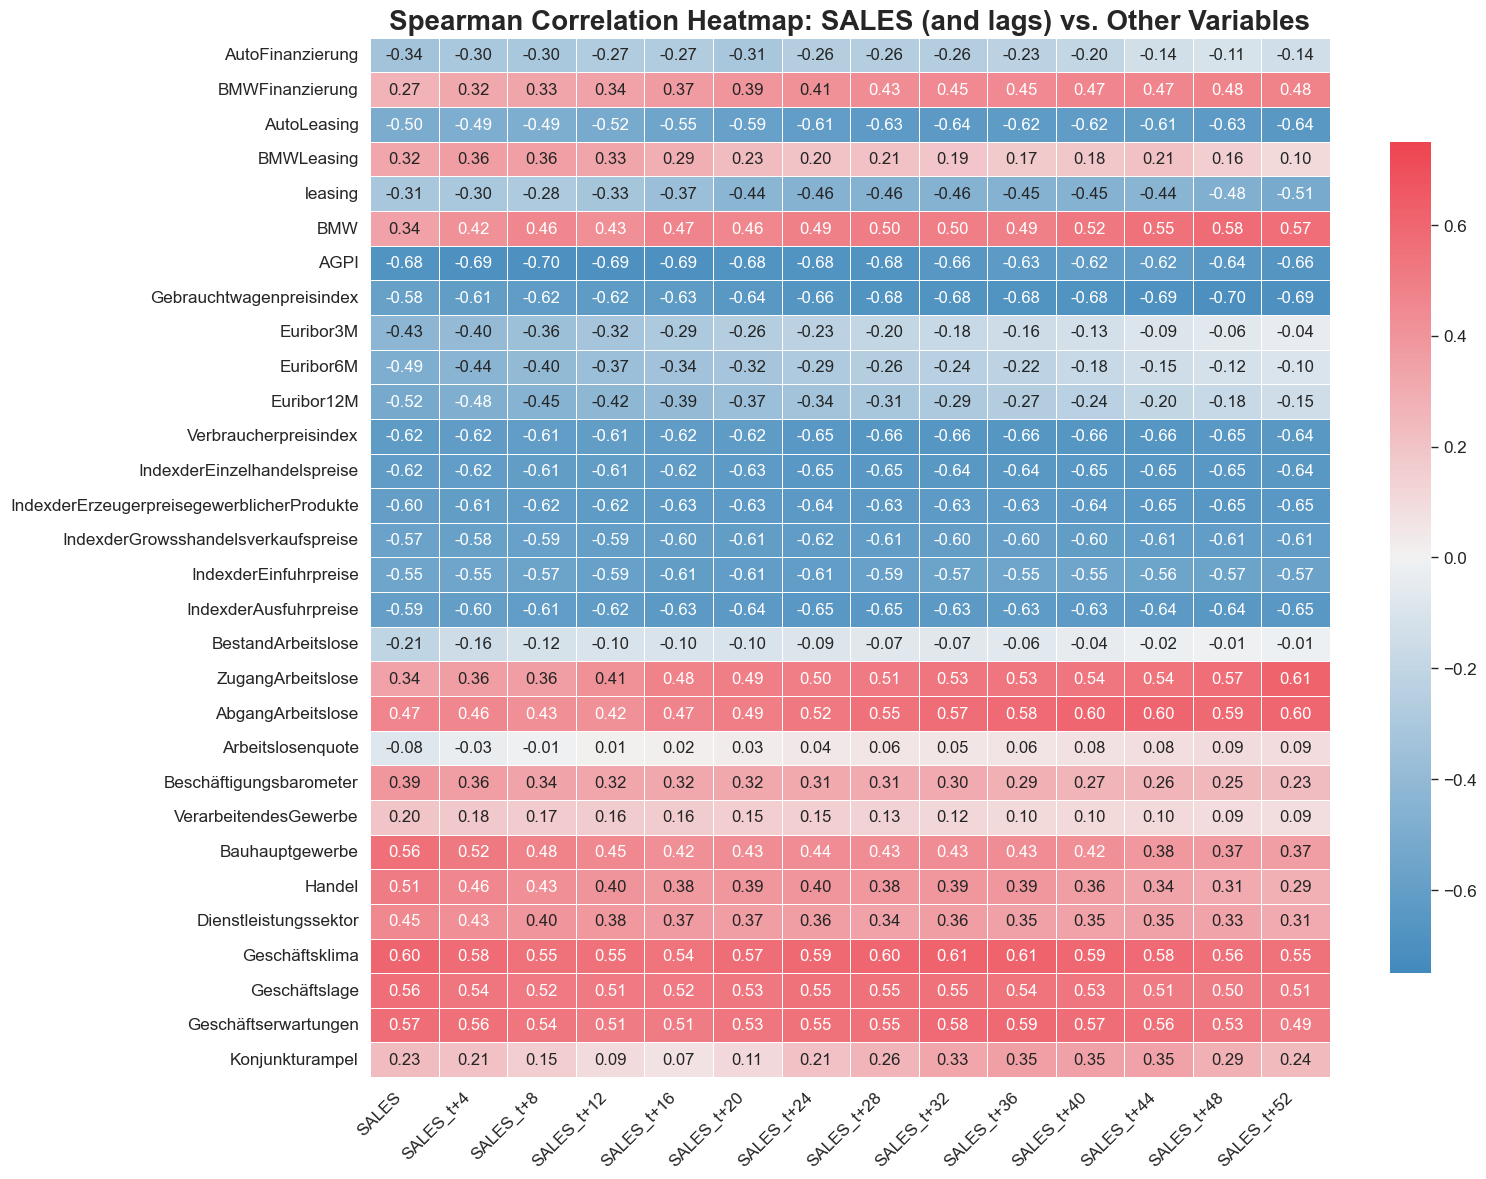

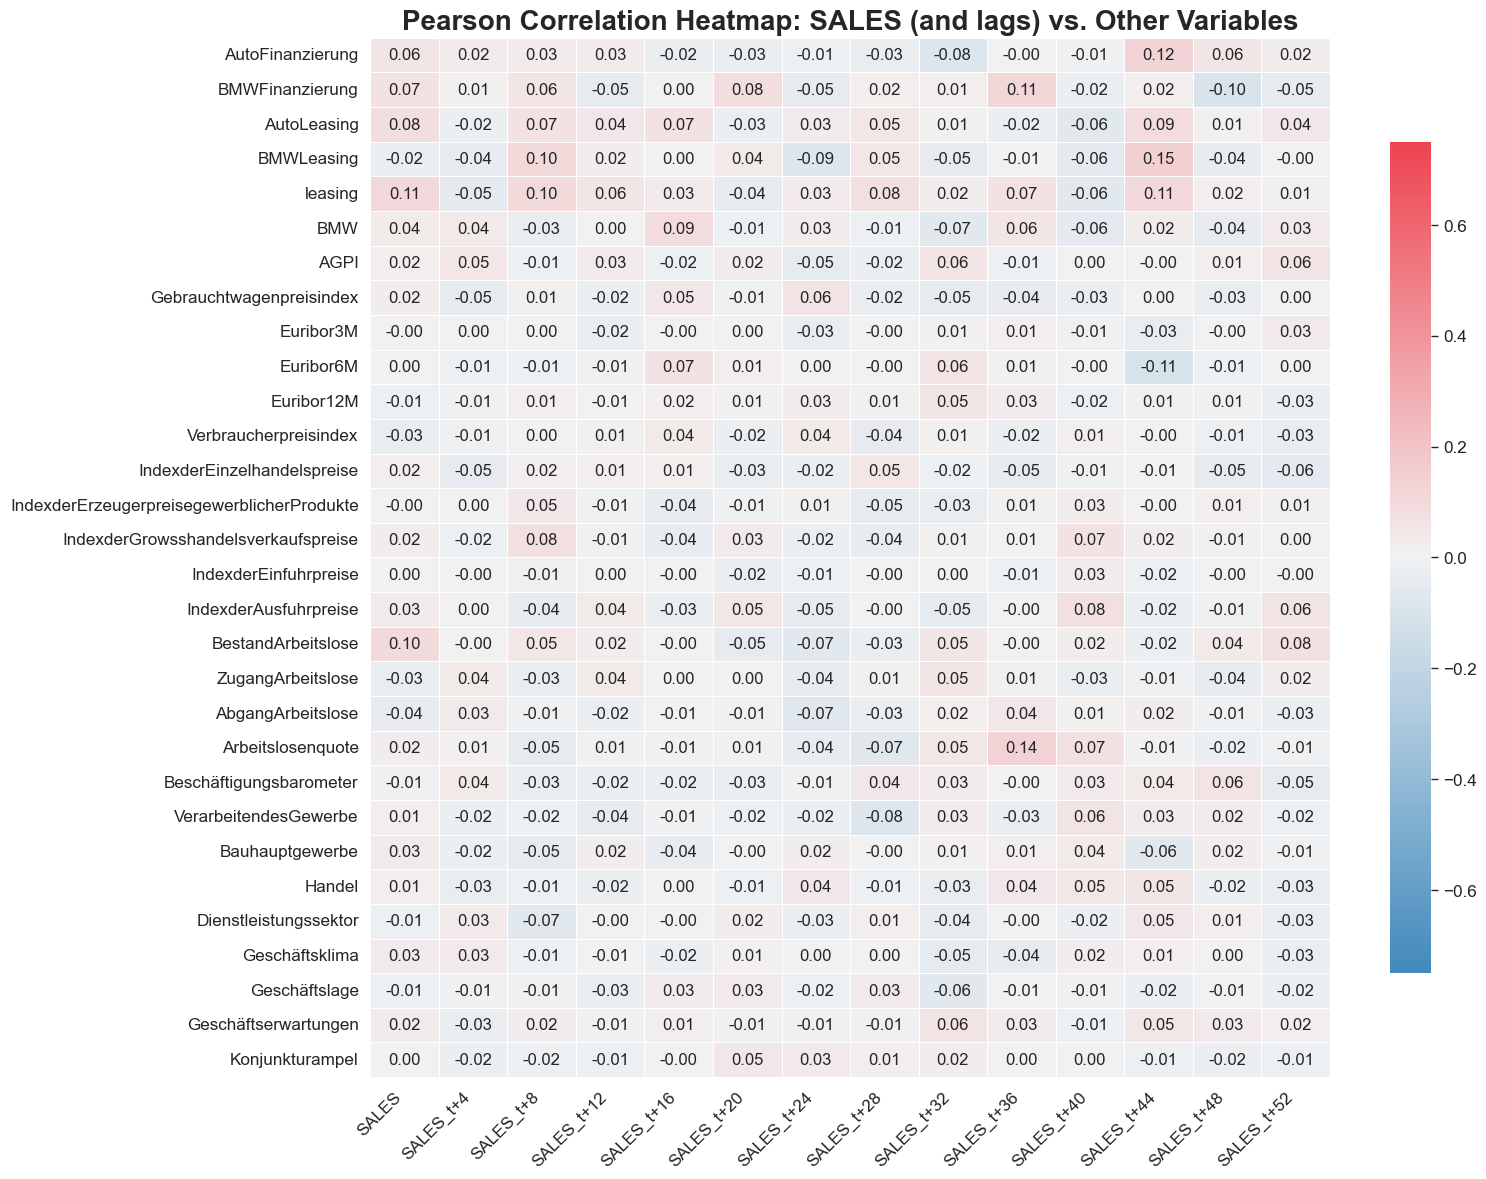

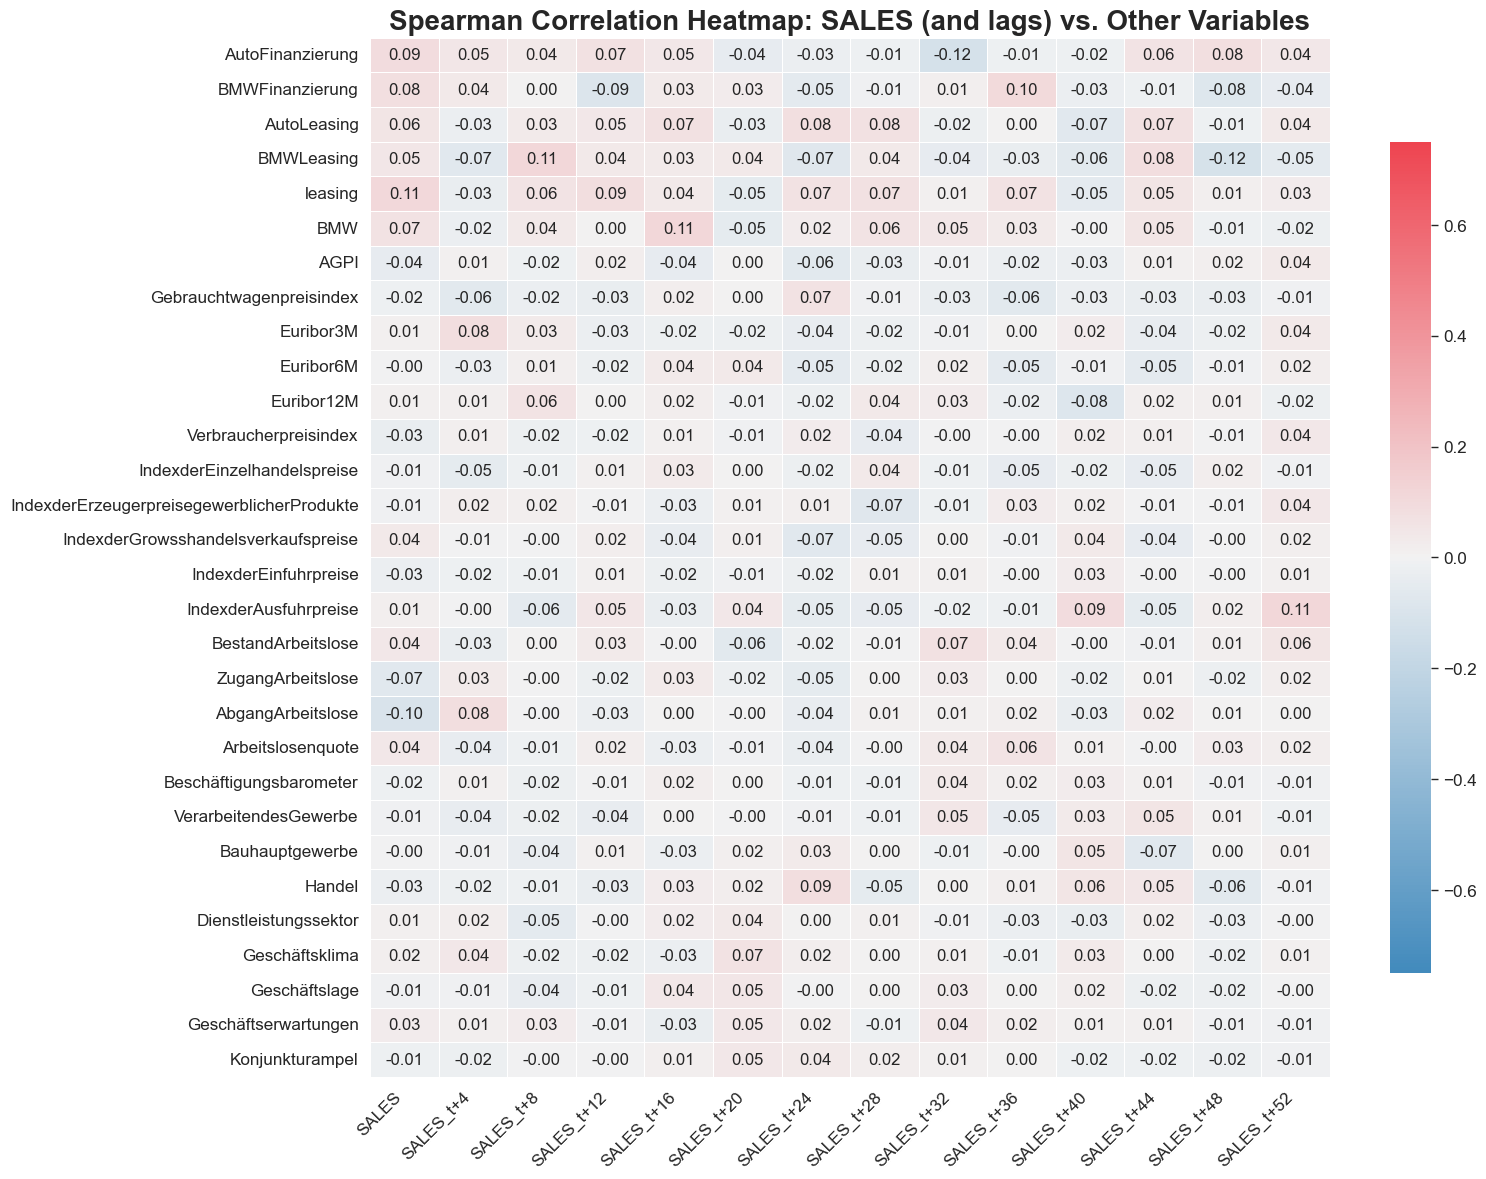

In [254]:
target_cols_fe = ["SALES"] + [f"SALES_t+{i}" for i in range(4, 53, 4)]
other_cols_fe = [col for col in df_fe.columns if col not in target_cols_fe + ["DATE"]]

generate_correlation_heatmap(df_fe, target_cols_fe, other_cols_fe)
generate_correlation_heatmap(df_differenced_fe, target_cols_fe, other_cols_fe)

In [ ]:
# VECM